In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
print(device_name)

import pickle
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D

from tensorflow.keras.applications import ResNet50

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')

/device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dp = "/content/drive/My Drive/Anomaly Detection/Version 2/pickled images and labels/batch1/resized1"
lp = "/content/drive/My Drive/Anomaly Detection/Version 2/pickled images and labels/batch1/labels1"

data, labels = pickle.loads(open(dp, "rb").read()), pickle.loads(open(lp, "rb").read())

In [7]:
le = LabelBinarizer()
labels = le.fit_transform(labels)

In [8]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.15, random_state=42, shuffle=True)

In [11]:
len(labels)

11521

In [ ]:
trainAug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    shear_range=0.10,
    horizontal_flip=True,
)

valAug = ImageDataGenerator()

In [ ]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(240, 320, 3)))

headModel = baseModel.output

headModel = AveragePooling2D(pool_size=(7, 7),)(headModel)

headModel = Flatten(name="flatten")(headModel)

headModel = Dense(512, kernel_regularizer=l2(0.0001), activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)

headModel = Dense(1, activation="sigmoid")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
BS = 128
EPOCHS = 5

print("[INFO] compiling model...")
# opt = SGD(lr=0.0001, momentum=0.7)
opt = Adam(lr=0.0001)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] training head...")

H = model.fit(
    x=trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)

[INFO] compiling model...
[INFO] training head...
Epoch 1/5
76/76 [==============================] - 130s 2s/step - loss: 0.3428 - accuracy: 0.8858 - val_loss: 0.1796 - val_accuracy: 0.9784
Epoch 2/5
76/76 [==============================] - 131s 2s/step - loss: 0.1771 - accuracy: 0.9691 - val_loss: 0.1309 - val_accuracy: 0.9856
Epoch 3/5
76/76 [==============================] - 132s 2s/step - loss: 0.1445 - accuracy: 0.9825 - val_loss: 0.1107 - val_accuracy: 0.9952
Epoch 4/5
76/76 [==============================] - 132s 2s/step - loss: 0.1260 - accuracy: 0.9871 - val_loss: 0.1132 - val_accuracy: 0.9904
Epoch 5/5
76/76 [==============================] - 132s 2s/step - loss: 0.1140 - accuracy: 0.9895 - val_loss: 0.1054 - val_accuracy: 0.9952


In [ ]:
name = 'model_weights.h5'

model.save_weights(name)

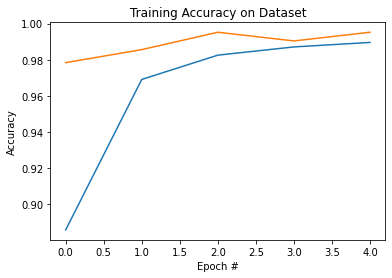

In [ ]:
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc");
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc");
plt.title("Training Accuracy on Dataset");
plt.xlabel("Epoch #");
plt.ylabel("Accuracy");

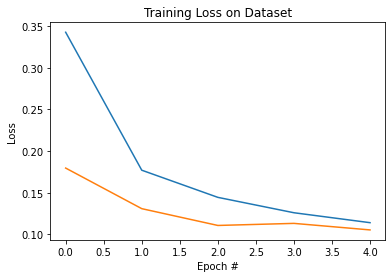

In [ ]:
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss");
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss");
plt.title("Training Loss on Dataset");
plt.xlabel("Epoch #");
plt.ylabel("Loss");

In [ ]:
ypred = model.predict(testX)

In [ ]:
pred = []
yp = ypred.reshape(1,-1)[0]
thresh = 0.5
for val in yp:
  if val>thresh:
    pred.append(1)
  else:
    pred.append(0)

ypred = np.array(pred).reshape(-1,1)

print('Classification Report:\n')
print(classification_report(testY,ypred))
print('Confusion Matrix:\n')
print(confusion_matrix(testY,ypred))

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       864
           1       1.00      0.99      0.99       865

    accuracy                           0.99      1729
   macro avg       0.99      0.99      0.99      1729
weighted avg       0.99      0.99      0.99      1729

Confusion Matrix:

[[863   1]
 [  8 857]]
